In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_local_pcn.builder import load_modules

load_modules()

In [4]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/maskcnn_polished_with_local_pcn'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit_certain_configs import param_iterator_obj
from key_utils import keygen

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(param_iterator_obj.generate()):
        if idx % 50 == 0:
            print(idx)
            
#         print(len(param))
        
        assert len(param) == 23
        assert param['split_seed'] == 'legacy'
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 9
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        _df_collect.append(
            {
#                 'split_seed': str(param['split_seed']),
                
                
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'input_size': param['input_size'],
                'loss_type': param['loss_type'],
                
                # 12 to go
                
                'scale': float(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 8 to go
                'pcn_bn': param['pcn_bn'],
                'pcn_bn_post': param['pcn_bn_post'],
                'pcn_bypass': param['pcn_bypass'],
                'pcn_final_act': param['pcn_final_act'],
                'pcn_no_act': param['pcn_no_act'],
                'pcn_bias': param['pcn_bias'],
                
                'pcn_cls': param['pcn_cls'],
                
                'model_seed': param['model_seed'],
                
#                 'corr_test': result['stats_best']['stats']['test']['corr_mean'],
                'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
        _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
            'act_fn', 'bn_before_act', 'bn_after_fc',
            'input_size', 'loss_type', 'scale',
            'smoothness',
            
            'pcn_bn', 'pcn_bn_post', 'pcn_bypass', 'pcn_final_act', 'pcn_no_act', 'pcn_bias', 'pcn_cls',
            'model_seed',
            
            'corr_test', 'num_param',
            'max_epoch',
            
                                                 ])
        _df = _df.set_index([
            'act_fn', 'bn_before_act', 'bn_after_fc',
            'input_size', 'loss_type', 'scale',
            'smoothness',
            'pcn_bn', 'pcn_bn_post', 'pcn_bypass', 'pcn_final_act', 'pcn_no_act', 'pcn_bias', 'pcn_cls',
            'model_seed',
        ],verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300


In [8]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)
corr_std = df['corr_test'].unstack('model_seed').std(axis=1)

In [9]:
corr_mean.unstack('pcn_cls')

pcn_cls                                                                                                                                          0  \
act_fn   bn_before_act bn_after_fc input_size loss_type scale smoothness pcn_bn pcn_bn_post pcn_bypass pcn_final_act pcn_no_act pcn_bias             
relu     False         False       50         mse       0.01  0.000005   False  False       False      False         False      True      0.587928   
                                                                                                       True          False      True      0.586200   
                                                                                True        False      False         False      True      0.610295   
                                                                                                       True          False      True      0.610295   
                                                                         True   False       False      False         False      True      0.612241   
                                                                                                       True          False      True      0.614303   
                                                                                True        False      False         False      True      0.620971   
                                                                                                       True          False      True      0.612300   
                                              poisson   0.01  0.000005   False  False       False      False         False      True      0.541808   
                                                                                                       True          False      True      0.521077   
                                                                                True        False      False         False      True      0.604928   
                                                                                                       True          False      True      0.604877   
                                                                         True   False       False      False         False      True      0.605910   
                                                                                                       True          False      True      0.599982   
                                                                                True        False      False         False      True      0.608346   
                                                                                                       True          False      True      0.605679   
                                   100        mse       0.01  0.000005   False  False       False      False         False      True      0.405738   
                                                                                                       True          False      True      0.406606   
                                                                                True        False      False         False      True      0.647658   
                                                                                                       True          False      True      0.647658   
                                                                         True   False       False      False         False      True      0.648466   
                                                                                                       True          False      True      0.660737   
                                                                                True        False      False         False      True      0.651314   
                                                                                                       True          False      True      0.653364   
                                              poisson   0.01  0.000005   False  False       False   

In [10]:
corr_std.unstack('pcn_cls')

pcn_cls                                                                                                                                          0  \
act_fn   bn_before_act bn_after_fc input_size loss_type scale smoothness pcn_bn pcn_bn_post pcn_bypass pcn_final_act pcn_no_act pcn_bias             
relu     False         False       50         mse       0.01  0.000005   False  False       False      False         False      True      0.002456   
                                                                                                       True          False      True      0.005813   
                                                                                True        False      False         False      True      0.006242   
                                                                                                       True          False      True      0.006242   
                                                                         True   False       False      False         False      True      0.008260   
                                                                                                       True          False      True      0.013488   
                                                                                True        False      False         False      True      0.008693   
                                                                                                       True          False      True      0.007731   
                                              poisson   0.01  0.000005   False  False       False      False         False      True      0.026879   
                                                                                                       True          False      True      0.046455   
                                                                                True        False      False         False      True      0.011513   
                                                                                                       True          False      True      0.011425   
                                                                         True   False       False      False         False      True      0.010413   
                                                                                                       True          False      True      0.014572   
                                                                                True        False      False         False      True      0.008568   
                                                                                                       True          False      True      0.001358   
                                   100        mse       0.01  0.000005   False  False       False      False         False      True      0.013876   
                                                                                                       True          False      True      0.014852   
                                                                                True        False      False         False      True      0.005481   
                                                                                                       True          False      True      0.005481   
                                                                         True   False       False      False         False      True      0.005678   
                                                                                                       True          False      True      0.012032   
                                                                                True        False      False         False      True      0.007704   
                                                                                                       True          False      True      0.002532   
                                              poisson   0.01  0.000005   False  False       False   

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def scatter(x, y, xlabel, ylabel, title):
    
    # only check high performing cases.
    selector = np.logical_and(x>=0.5, y>=0.5)
    x=x[selector]
    y=y[selector]
    
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0.4,0.8)
    plt.ylim(0.4,0.8)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

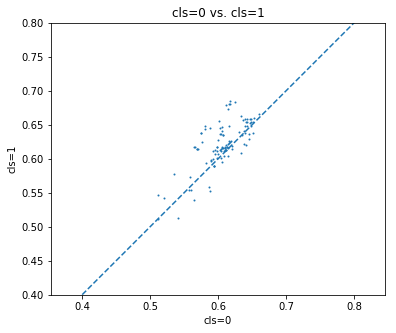

y-x mean 0.015303726406249918 y-x>0 mean 0.7757009345794392
y top 0.6846209081365385 x top 0.6607371521587203


In [12]:
scatter(corr_mean.unstack('pcn_cls').values[:,0], corr_mean.unstack('pcn_cls').values[:,1], 'cls=0', 'cls=1', 'cls=0 vs. cls=1')

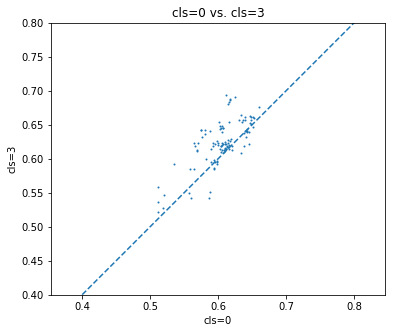

y-x mean 0.018789391909521582 y-x>0 mean 0.8055555555555556
y top 0.6938537086954857 x top 0.6607371521587203


In [13]:
scatter(corr_mean.unstack('pcn_cls').values[:,0], corr_mean.unstack('pcn_cls').values[:,3], 'cls=0', 'cls=3', 'cls=0 vs. cls=3')

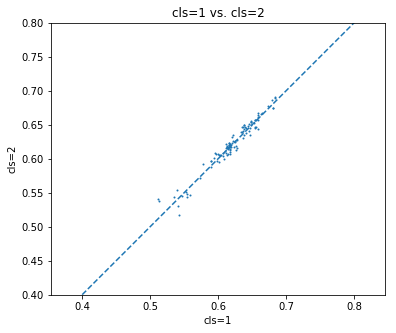

y-x mean 0.0015169921956972106 y-x>0 mean 0.6146788990825688
y top 0.6903830970729269 x top 0.6846209081365385


In [14]:
scatter(corr_mean.unstack('pcn_cls').values[:,1], corr_mean.unstack('pcn_cls').values[:,2], 'cls=1', 'cls=2', 'cls=1 vs. cls=2')

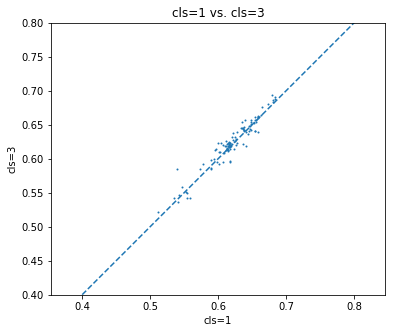

y-x mean 0.0030781310349402577 y-x>0 mean 0.7037037037037037
y top 0.6938537086954857 x top 0.6846209081365385


In [15]:
scatter(corr_mean.unstack('pcn_cls').values[:,1], corr_mean.unstack('pcn_cls').values[:,3], 'cls=1', 'cls=3', 'cls=1 vs. cls=3')

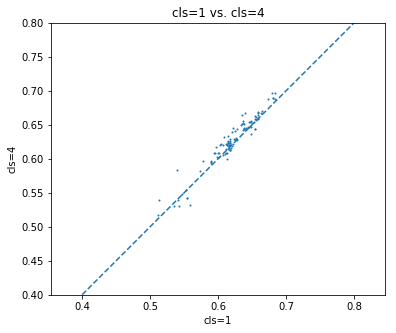

y-x mean 0.00632648408437849 y-x>0 mean 0.7889908256880734
y top 0.6975102080500837 x top 0.6846209081365385


In [16]:
scatter(corr_mean.unstack('pcn_cls').values[:,1], corr_mean.unstack('pcn_cls').values[:,4], 'cls=1', 'cls=4', 'cls=1 vs. cls=4')

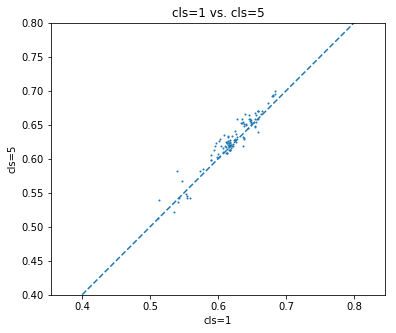

y-x mean 0.007068685575575876 y-x>0 mean 0.7614678899082569
y top 0.699843794435775 x top 0.6846209081365385


In [17]:
scatter(corr_mean.unstack('pcn_cls').values[:,1], corr_mean.unstack('pcn_cls').values[:,5], 'cls=1', 'cls=5', 'cls=1 vs. cls=5')

In [18]:
from thesis_v2.plots.util import savefig

(128, 6)
0.8515625
[0, 1, 2, 3, 4, 5]
n 109
1 - 0 mean 0.014380849098473241 sem 0.0023702341164843644
2 - 1 mean 0.002291137298130233 sem 0.0009046558249784212
3 - 2 mean 0.0015608072801898596 sem 0.0008997546343755884
5 - 3 mean 0.004519185437958944 sem 0.0009231438633473878
5 - 2 mean 0.006079992718148804 sem 0.001086302737924213


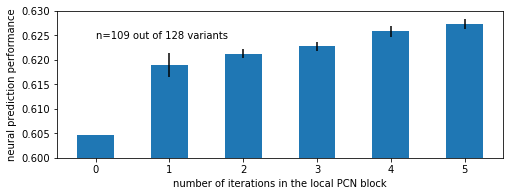

In [19]:
def plot_step_increase(pairs_to_check):
    # remove those no innner act ones.
    df_unstacked = corr_mean.unstack('pcn_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
    selector = df_unstacked.values[:,0] >= 0.50
#     selector = ()
    print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(len(cls_values)))
    
    n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1][selector]
        val1 = df_unstacked.values[:,p2][selector]

        # selection
        
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
    plt.ylabel('neural prediction performance')
    plt.ylim(0.6, 0.63)
    plt.xlabel('number of iterations in the local PCN block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0, 0.625, f'n={n} out of {selector.size} variants', verticalalignment='center', horizontalalignment='left')
    fig.subplots_adjust(bottom=0.2)
    savefig(fig, 'yuanyuan_8k_a_3day/maskcnn_polished_with_local_pcn/basic_for_certain_configs/main_cc2normed.pdf')
    
    plt.show()
    
    
    
# trend for 0-1-2 is good. then bad.
plot_step_increase([(0,1),(1,2),(2,3),(3,5),(2,5)])

In [20]:
corr_mean.unstack('pcn_cls')

pcn_cls                                                                                                                                          0  \
act_fn   bn_before_act bn_after_fc input_size loss_type scale smoothness pcn_bn pcn_bn_post pcn_bypass pcn_final_act pcn_no_act pcn_bias             
relu     False         False       50         mse       0.01  0.000005   False  False       False      False         False      True      0.587928   
                                                                                                       True          False      True      0.586200   
                                                                                True        False      False         False      True      0.610295   
                                                                                                       True          False      True      0.610295   
                                                                         True   False       False      False         False      True      0.612241   
                                                                                                       True          False      True      0.614303   
                                                                                True        False      False         False      True      0.620971   
                                                                                                       True          False      True      0.612300   
                                              poisson   0.01  0.000005   False  False       False      False         False      True      0.541808   
                                                                                                       True          False      True      0.521077   
                                                                                True        False      False         False      True      0.604928   
                                                                                                       True          False      True      0.604877   
                                                                         True   False       False      False         False      True      0.605910   
                                                                                                       True          False      True      0.599982   
                                                                                True        False      False         False      True      0.608346   
                                                                                                       True          False      True      0.605679   
                                   100        mse       0.01  0.000005   False  False       False      False         False      True      0.405738   
                                                                                                       True          False      True      0.406606   
                                                                                True        False      False         False      True      0.647658   
                                                                                                       True          False      True      0.647658   
                                                                         True   False       False      False         False      True      0.648466   
                                                                                                       True          False      True      0.660737   
                                                                                True        False      False         False      True      0.651314   
                                                                                                       True          False      True      0.653364   
                                              poisson   0.01  0.000005   False  False       False   